# Swan Project, Analysis of Churners - Team 7

This notebook analyses customer churn for Swan Teleco.  

Objectives:
- Identify who is churning and why.
- Train predictive models to assign churn probabilities.
- Deliver two actionable outputs:
  1. List of top 500 customers at highest churn risk.
  2. Churn probability scores for all customers.


## 0. Imports

In [153]:
# Import statements and set up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from matplotlib.colors import to_rgb
from matplotlib.patches import Patch

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,  roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

two_palette=['#2c3e6c', '#b0c4de']
three_palette = ['#2c3e6c', '#b0c4de', '#98A8B6']
five_palette = ['#2c3e6c', '#b0c4de', '#98A8B6', '#7F8C8D', '#2A2A2A']

## 1. Exploratory Data Analysis
### 1.1. Initial Checks
We first investigated the dataset to explore whether there was any anomalous data, as well as establishing basic insights into which types of customers are likely to churn and why they would do so.

In [154]:
df = pd.read_csv("Project_Data.csv")
print("Data Shape:", df.shape)
print("Data Nulls:\n", df.isna().sum())

Data Shape: (7043, 31)
Data Nulls:
 CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Reason         5174
dtype: int64


We initially briefly investigate the nulls located within Churn Reason to establish the reason for this large number of nulls, finding that there are only nulls for 'Churn Reason' when the customer has not churned, which is wholly logical and thus means the data is consistent still with these nulls.

In [155]:
# this shows that the only null values are for reason when churn value is 0 which is wholly logical.
nullReason = df[df['Churn Reason'].isna()].copy()
nullReason['Churn Value'].value_counts()

Churn Value
0    5174
Name: count, dtype: int64

### 1.2. Renaming columns

We rename the variables to more standard coding practices.

In [156]:
# Rename columns for consistency
df = df.rename(columns={
    'CustomerID': 'customer_id',
    'Churn Label': 'churn_flag',
    'Churn Value': 'churn_value',
    'Churn Reason': 'churn_reason',
    'Tenure Months': 'tenure_months',
    'Monthly Charges': 'monthly_charges',
    'Total Charges': 'total_charges'
})

### 1.3. Demographics of churners
We explore different visualisations of relationships between churners and different features within the dataset.
Prior to doing this, we note that we normalise our values within the graph so that we give a percentage of the total number of people who did or didn't churn. We give this as a mathematical calculation for context:

$\text{Percentage(\%) = \text{Count of entries with flag in that column} / \text{Count of total entries with flag}}$

Below, we visualise the relationships between different properties of people, be that their relationships, whether they care for anyone or their gender.

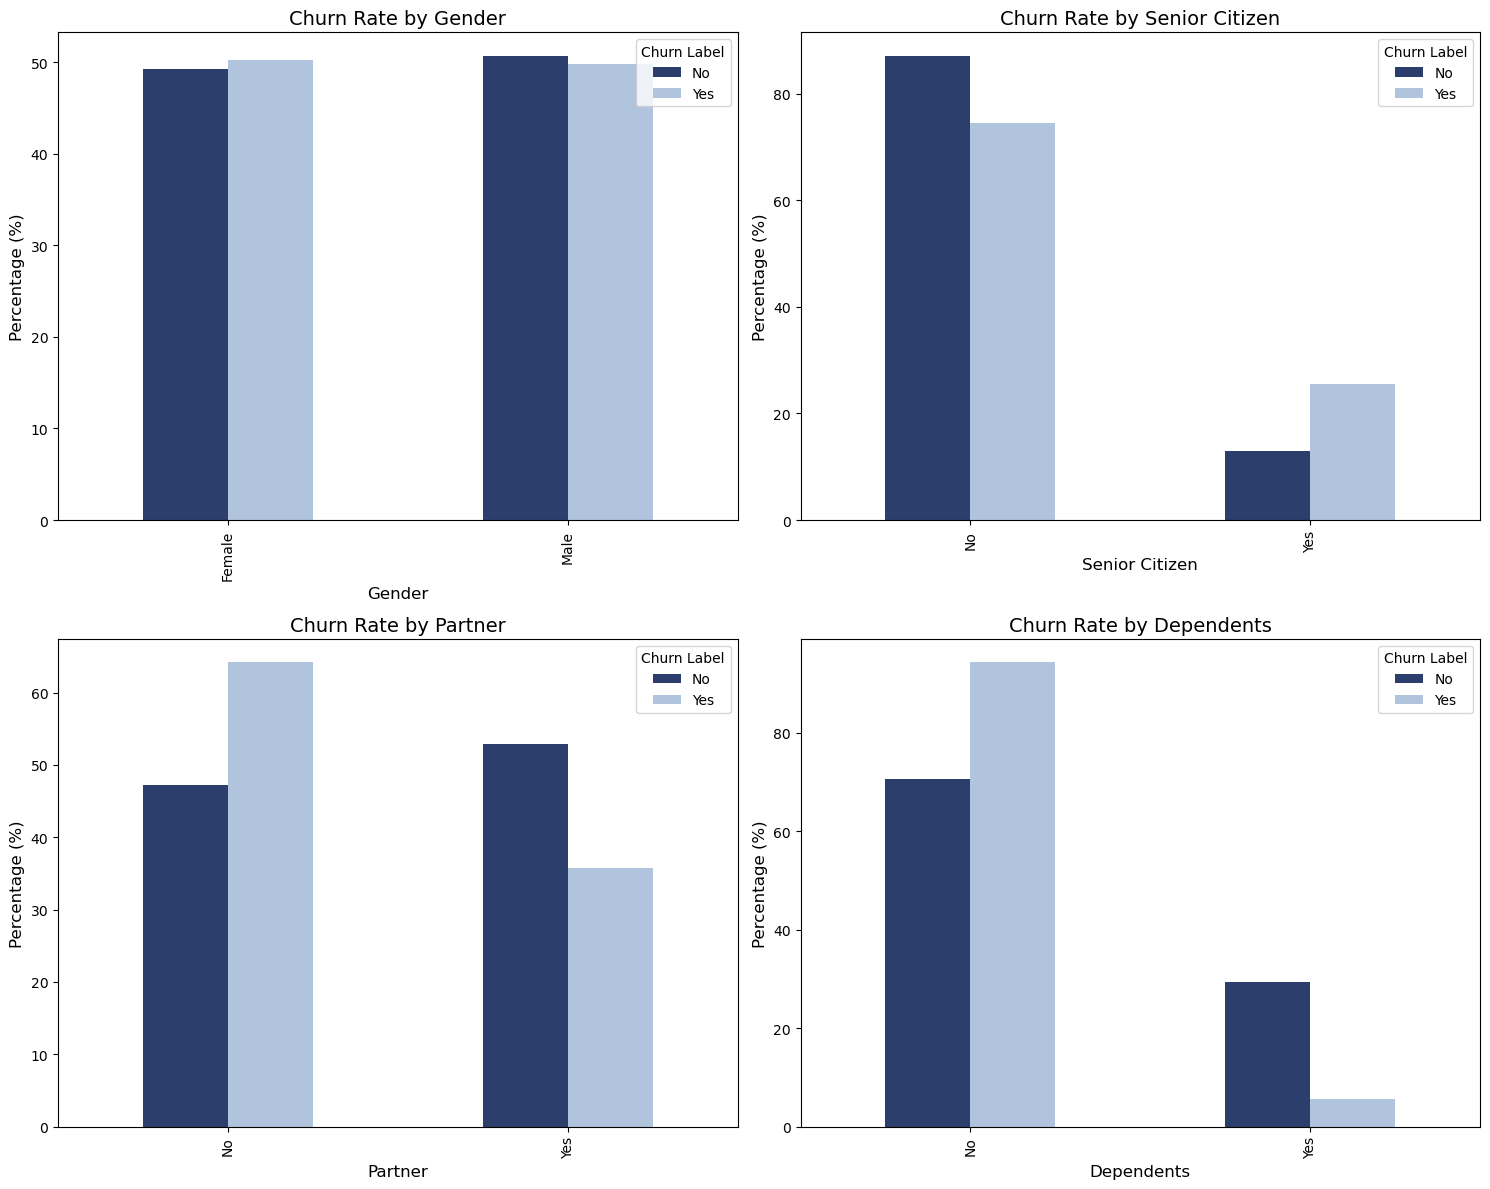

In [157]:
#Demographic Analysis - Cool Visualizations
columns = ['Gender', 'Senior Citizen', 'Partner', 'Dependents']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df[col], df['churn_flag'], normalize='columns') * 100
    # Create bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=two_palette[:len(crosstab.columns)])

    # Set titles and labels
    axes[idx].set_title('Churn Rate by ' + col, fontsize=14)
    axes[idx].set_xlabel(col, fontsize=12)
    # We use percentages so that the data is  scaled appropriately.
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)
    axes[idx].legend(title='Churn Label', loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

From the above graphs, we make the following brief insights:
- *Gender* does not seem to have an effect on someone churning.
- *Senior citizens* have a higher chance of churning, whereas people with *partners* or *dependents* have a lower chance of churning.

We now proceed to visualise and review how different contractual/financial obligations may affect people churning.

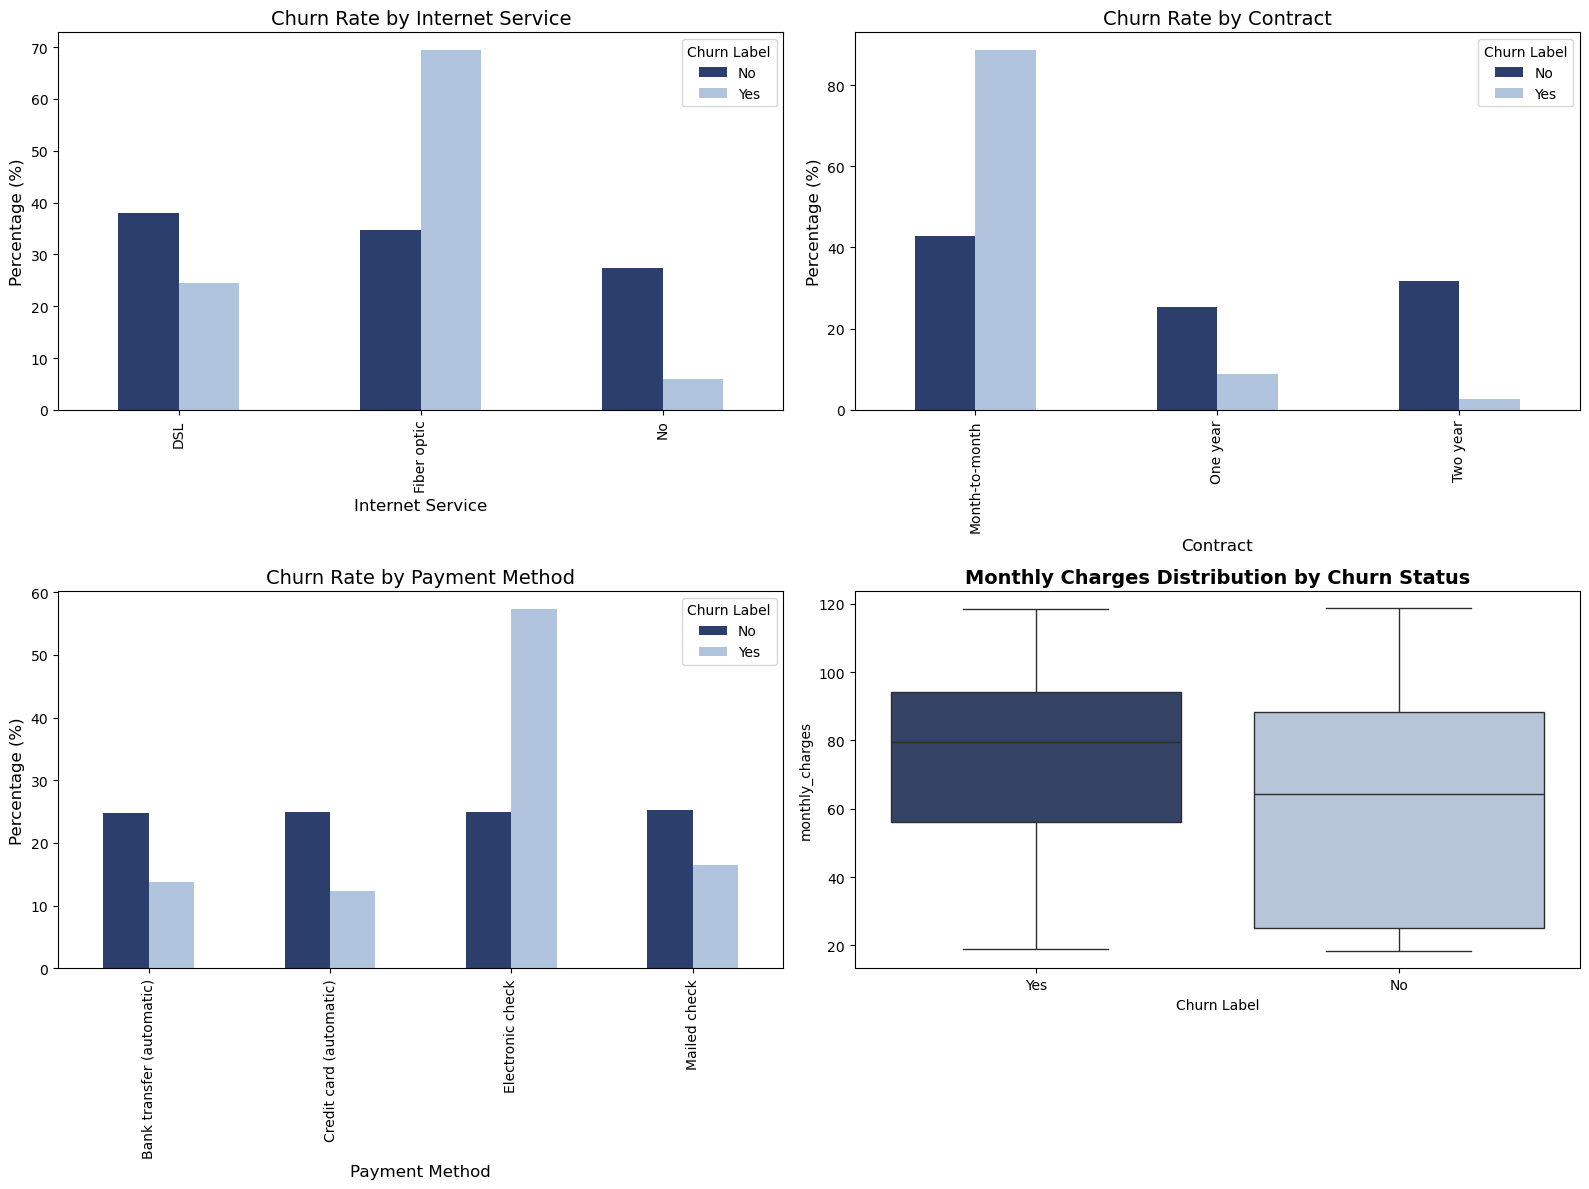

In [158]:
# Payments and Internet Service Graphs
columns = ['Internet Service', 'Contract', 'Payment Method']
# Service Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df[col], df['churn_flag'], normalize='columns') * 100
    # Create bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=two_palette[:len(crosstab.columns)])

    # Set titles and labels
    axes[idx].set_title('Churn Rate by ' + col, fontsize=14)
    axes[idx].set_xlabel(col, fontsize=12)
    # We use percentages so that the data is  scaled appropriately.
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)
    axes[idx].legend(title='Churn Label', loc='upper right', fontsize=10)

sns.boxplot(data=df, x='churn_flag', y='monthly_charges', ax=axes[3], palette=two_palette, hue = 'churn_flag')
axes[3].set_title('Monthly Charges Distribution by Churn Status', fontsize=14, fontweight='bold')
axes[3].set_xlabel('Churn Label')

plt.tight_layout()
plt.show()

These all have the highest churn rate of their respective contractual categories:
- *Fiber optic*. This could be a market that could be tapped into more and have incentives given to customers to reduce churning within this area.
- *Month to month*, which is logical due to the lesser commitment than other contract types.
- *Electronic checks*. This lines up with common sense that automatic bank cards payments have a much lower churn rate than that of a very manually done process such as checks.

It also follows that customers with a higher monthly on average are more likely to be inclined to churn, most likely swayed by competitors with a way of saving money. 

We now specifically review add-ons to the internet service scheme offered by Swan Teleco to review which of these add-ons help to reduce churning. Please note for this data we only reviewed customers who had signed up for *Internet Service* as these are the only customers who will have had access to these add-ons, helping to linearise conclusions from these visualisations.

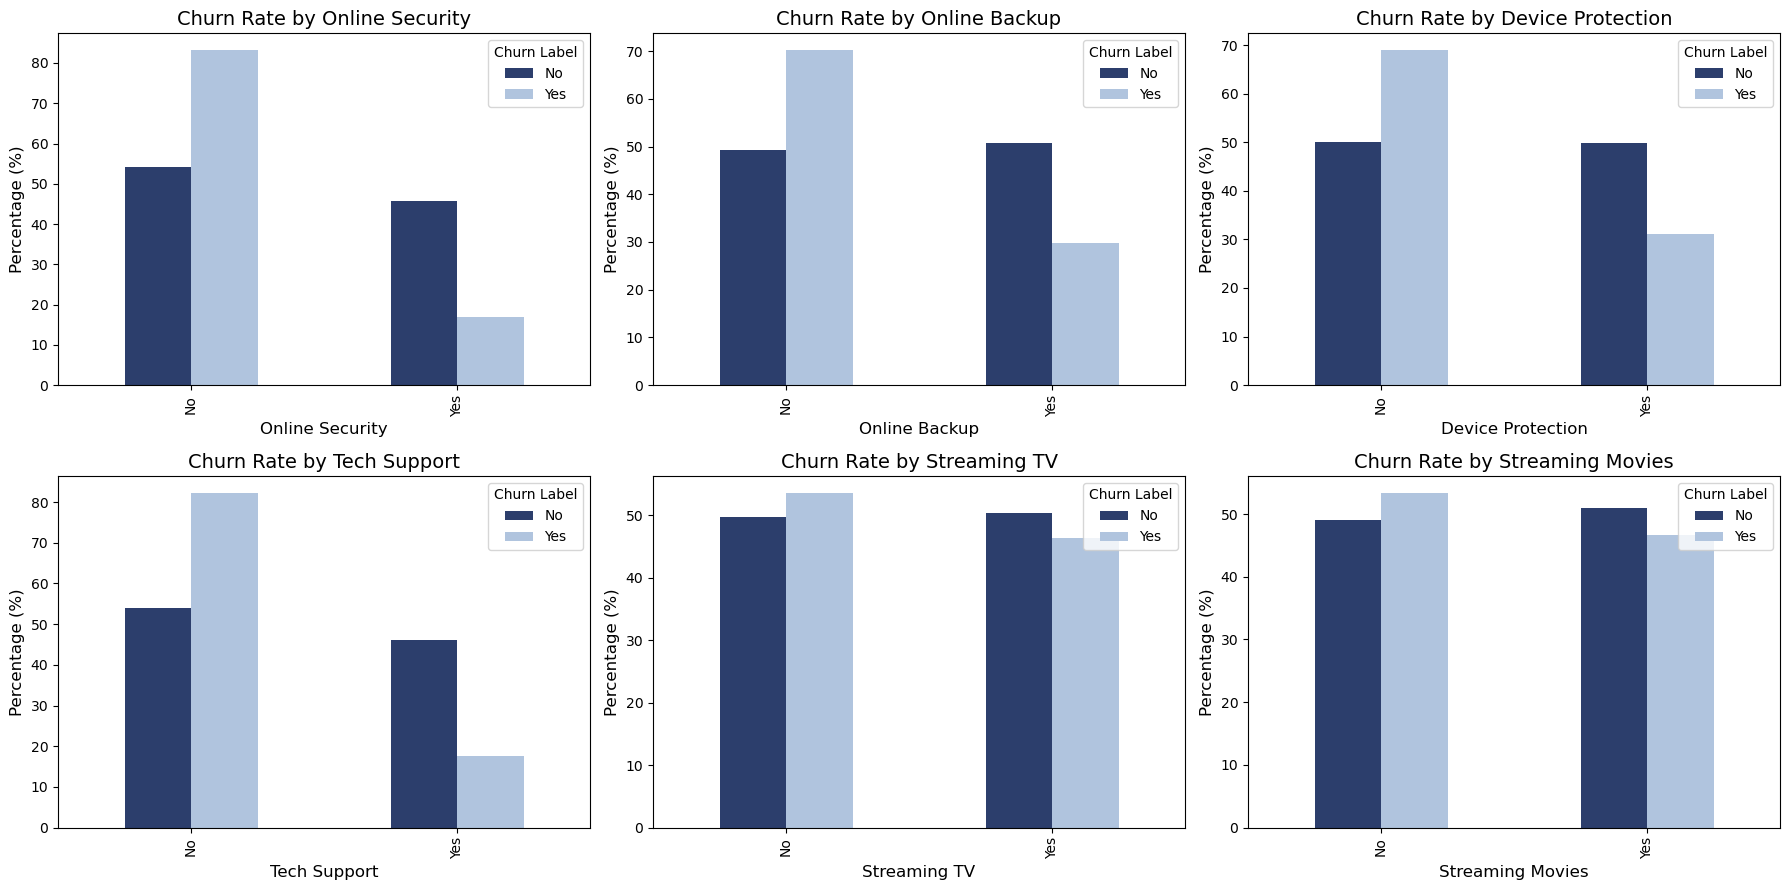

In [159]:
# Columns to analyze
columns = ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support','Streaming TV', 'Streaming Movies']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 9))
axes = axes.flatten()

# Remove rows where InternetService is 'No'
df_internet = df[df['Internet Service'] != 'No']

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df_internet[col], df_internet['churn_flag'], normalize='columns') * 100

    # Create bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=two_palette[:len(crosstab.columns)])

    # Set titles and labels
    axes[idx].set_title('Churn Rate by ' + col, fontsize=14)
    axes[idx].set_xlabel(col, fontsize=12)
    # We use percentages so that the data is  scaled appropriately.
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)
    axes[idx].legend(title='Churn Label', loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

It can be seen that tech add ons such as:
- Online security
- Online backup
- Device protection
- Tech support

All reduce churn rate, whereas TV & Movie streaming services do not reduce churn by a noticeable amount.

With this, we move to reviewing the *Phone Service* scheme offered, along with the add-on of *Multiple Lines* to see if these have any impact on churning.

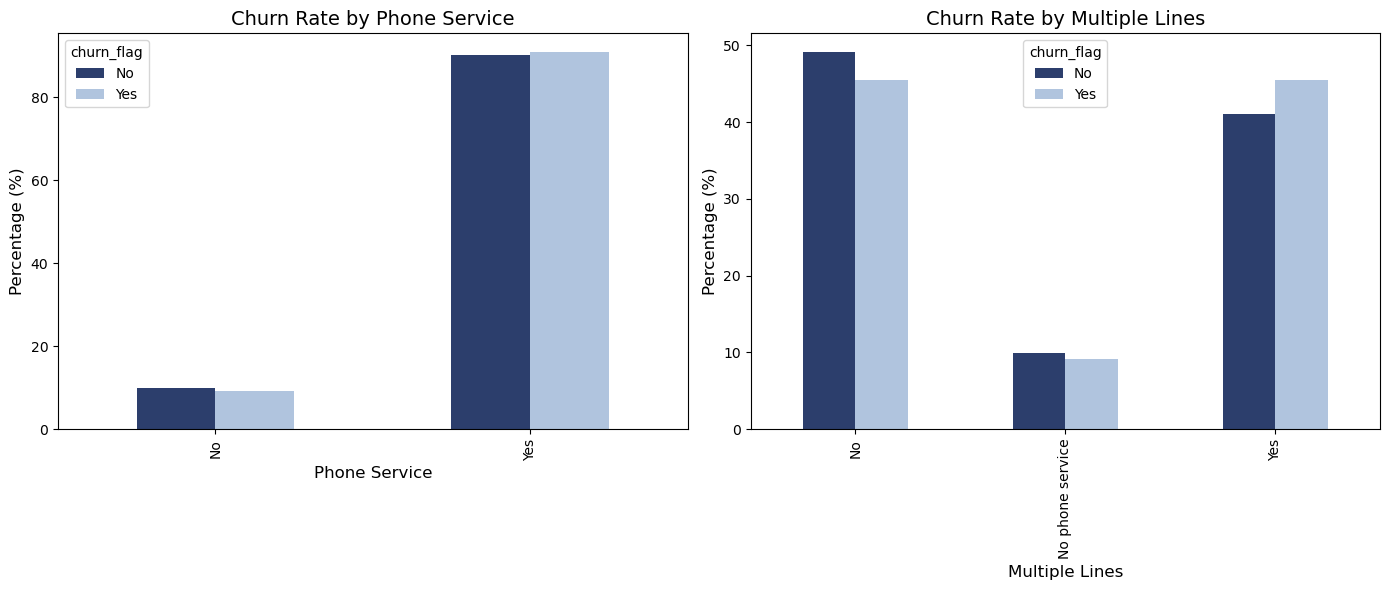

In [160]:
# Columns to analyze
columns = ['Phone Service', 'Multiple Lines']

# Create subplots
fig, axes = plt.subplots(1, len(columns), figsize=(14, 6))

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df[col], df['churn_flag'], normalize='columns') * 100

    # Create horizontal bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=two_palette[:len(crosstab.columns)])

    # Set titles and labels
    axes[idx].set_title('Churn Rate by ' + col, fontsize=14)
    axes[idx].set_xlabel(col, fontsize=12)
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)

plt.tight_layout()
plt.show()

Neither Phone service nor Multiple lines seem to affect churn by a reasonable amount, and so can be disregarded as potential impactors of churning.

With this, we now review churn rate with respect to tenure duration, seeing how customers churning changes with time spent with the service.

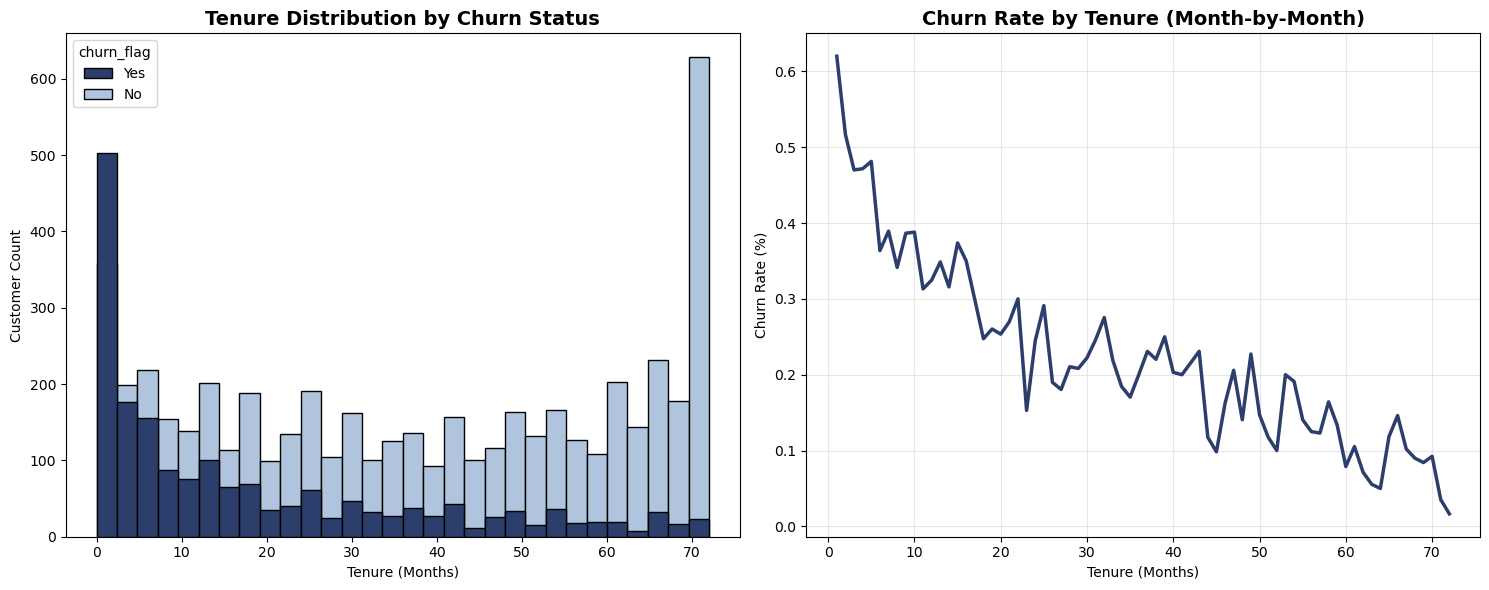

In [161]:
# Tenure Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# LHS
sns.histplot(
    data=df,
    x='tenure_months',
    hue='churn_flag',
    bins=30,
    ax=axes[0],
    palette=two_palette,
    alpha=1
)
axes[0].set_title('Tenure Distribution by Churn Status', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tenure (Months)')
axes[0].set_ylabel('Customer Count')

# RHS
tenure_month_churn = (
    df.groupby('tenure_months')['churn_value']
    .mean()
    .reset_index()
    .rename(columns={'churn_value': 'churn_rate'})
)
tenure_month_churn = tenure_month_churn[tenure_month_churn['tenure_months'] > 0]
sns.lineplot(
    data=tenure_month_churn,
    x='tenure_months',
    y='churn_rate',
    ax=axes[1],
    color='#2c3e6c',
    linewidth=2.5
)
axes[1].set_title('Churn Rate by Tenure (Month-by-Month)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tenure (Months)')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

It can be seen that the churn rate of customers is vastly affected by tenure, with the length of tenure having a negative correlation with churn rate. This is seen to be Swan Teleco's leading incentive in regards to having a positive effect on users churning, and is perhaps something to recommend pushing in marketing through a loyalty scheme of sorts or something along those lines.

Having reviewed different demographics of churners, along with the effect of services on customer retention rates, we now look at what specifically can be seen as driving customers to churn.

### 1.3. Churn Drivers
We investigated what led to customers churning, by counting and ordering the reasons that churned customers gave as to their reasoning for leaving the service.

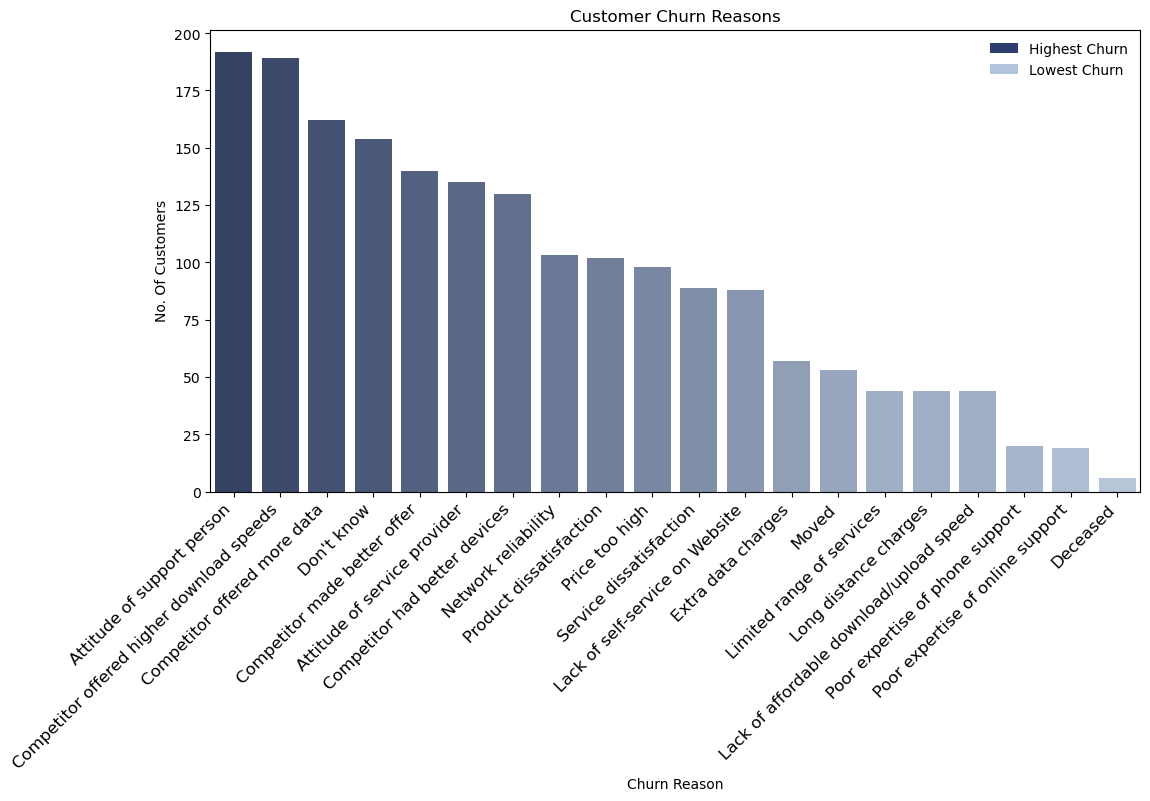

In [162]:
# Graphing the top reasons customers gave for churning
# Convert hex to RGB tuples


start_rgb = to_rgb(five_palette[1])
end_rgb = to_rgb(five_palette[0])

# Create a custom palette by interpolating between the two
n_colors = 18  # Number of colors in the palette
palette = [
    (
        start_rgb[0] + (end_rgb[0] - start_rgb[0]) * i / (n_colors - 1),
        start_rgb[1] + (end_rgb[1] - start_rgb[1]) * i / (n_colors - 1),
        start_rgb[2] + (end_rgb[2] - start_rgb[2]) * i / (n_colors - 1)
    )
    for i in range(n_colors)
]
churnValue_Reason = df[['churn_value', 'churn_reason']]
churnValue_Reason
churned = churnValue_Reason[churnValue_Reason['churn_value'] == 1]
reasonCounts = churned.value_counts()
reasonCounts = pd.DataFrame(reasonCounts).reset_index().rename(columns={'index': 'churn_reason', 0: 'Count'})
reasonCounts
plt.figure(figsize=(12,6))
sns.barplot(x=reasonCounts['churn_reason'], y=reasonCounts['count'], palette=palette, hue = reasonCounts['count'])
plt.xlabel('Churn Reason')
plt.xticks(rotation= 45, # rotating labels
           horizontalalignment = 'right', # aligning them with the bars
           fontweight = 'light',
           fontsize = 'large' # setting the fonts
          )
plt.ylabel('No. Of Customers')
plt.title('Customer Churn Reasons')
# Create custom legend with first and last colors
legend_elements = [
    Patch(facecolor=palette[-1], label='Highest Churn'),
    Patch(facecolor=palette[0], label='Lowest Churn')
]
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1), frameon=False)
plt.show()

It can be seen that the top 3 reasons customers gave for leaving come down to:
- Disappointing attitude from customer support.
- Competitive offers providing a better a deal for the user.

Having gathered this insight, we now review overall correlations to see what we can establish, primarily in regards to what correlates to *churn_value* as a negative correlation implies a feature that pushes customers to stay, and a positive correlation being a feature that does the opposite.

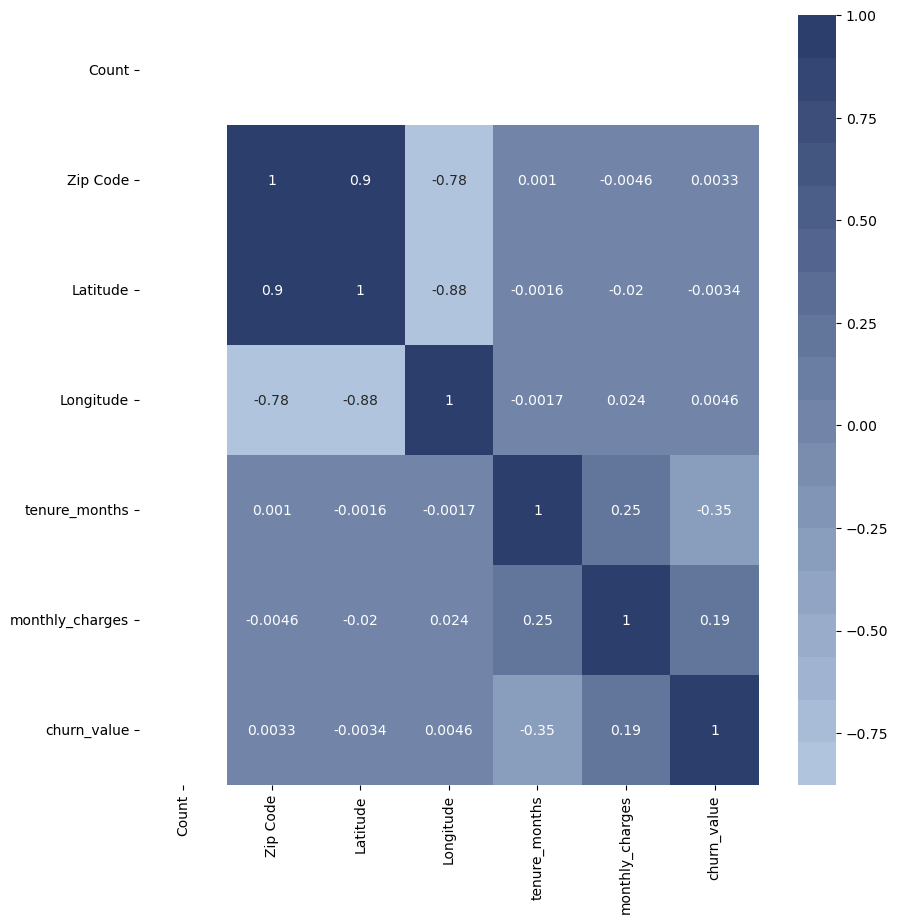

In [163]:
# Creating correlation to see what factors have a negative correlation with churn value.
plt.figure(figsize = (10,10))
sns.heatmap(data = df.corr(numeric_only = True),
            cmap = palette,
            annot = True)
plt.show()

In [164]:
# Creating churn rate summary table
def churn_rate_summary_fixed(df, features, churn_col='churn_flag'):
    """
    Creates a table with churn % for 'Yes' and 'No' values and Δ%.
    Handles columns with 'No internet service' or 'No phone service'.
    """
    results = []

    df_local = df.copy()

    # Normalize "No internet service"/"No phone service" → "No"
    df_local = df_local.replace({
        'No internet service': 'No',
        'No phone service': 'No'
    })

    for col in features:
        if col not in df_local.columns:
            continue

        churn_table = (
            df_local.groupby(col)[churn_col]
            .apply(lambda x: (x == 'Yes').mean() * 100 if df[churn_col].dtype == 'object' else x.mean() * 100)
        )

        yes_rate = churn_table.get('Yes', np.nan)
        no_rate  = churn_table.get('No', np.nan)
        delta    = yes_rate - no_rate if (not np.isnan(yes_rate) and not np.isnan(no_rate)) else np.nan

        results.append({
            'Feature': col,
            'Churn % (Yes)': round(yes_rate, 2) if not np.isnan(yes_rate) else None,
            'Churn % (No)': round(no_rate, 2) if not np.isnan(no_rate) else None,
            'Δ % (Yes - No)': round(delta, 2) if not np.isnan(delta) else None
        })

    return pd.DataFrame(results).sort_values(by='Δ % (Yes - No)', ascending=False).reset_index(drop=True)


# Include both demographics & service features
features = [
    'Paperless Billing', 'Phone Service', 'Multiple Lines',
    'Online Security', 'Online Backup', 'Device Protection',
    'Tech Support', 'Streaming TV', 'Streaming Movies'
]

summary_table = churn_rate_summary_fixed(df, features)
summary_table

,Feature,Churn % (Yes),Churn % (No),Δ % (Yes - No)
0,Paperless Billing,33.57,16.33,17.24
1,Streaming TV,30.07,24.33,5.74
2,Streaming Movies,29.94,24.38,5.56
3,Multiple Lines,28.61,25.02,3.59
4,Phone Service,26.71,24.93,1.78
5,Device Protection,22.50,28.65,-6.15
6,Online Backup,21.53,29.17,-7.64
7,Tech Support,15.17,31.19,-16.02
8,Online Security,14.61,31.33,-16.72


We create a summary table to provide the delta difference between the churn rates for several important features, as well as to provide a strong figure to include within our information deck. Here, a positive value implies that it is a feature that can be seen to lead customers to churn, and the opposite for features with a negative difference.

### Exploratory Data Analysis Conclusion
To summarise our primary findings from our EDA, we conclude that:
* In regards to demographics, the main takeaways are that senior citizens are the primary area for concern in regards to a higher churn rate.
* Customers who have Fibre Optic, as well as ones who are under a month to month contract are both likely to churn and may need incentives to stay. This could come in the form of raising awareness about the benefits of brand loyalty. This also matches well with the fact that *Tenure Months* were found to be the biggest negative correlator to people churning, meaning that it is a strong incentive that leads to people staying.
* Tech add ons such as Online Security and Backup all seem to be effective at reducing churn, whilst streaming add ons do not have much of an impact.
* The primary reasons given by customers for churning came down to disappointment in customer support, or better offerings from competitors. Thus, if there was an area to focus on competitive offerings, it would be best in improving the service given to customers using Fibre Optic potentially, for example.

With the data explored and insights established, we moved to investigating two seperate models to ensure we have an optimal method with which to generate the risk of any specific customer churning.


## 2. Modelling Churn Risk
We begin by creating two basic models from which we can begin to assess the potential risk of customers churning.

This innvoles the following steps:
* Feature engineering non-numerical features
* Dropping features not used in modelling
* Splitting our data into a training and testing set to evaluate performace accurately
* Filling missing values
* Scaling the data
* Train a random forest model
* Train a logistic regression model
* Calculate some metrics to compare our two models
* Select best on accuracy & f1 score  

### 2.1. Feature Engineering

In [165]:
# Feature engineering function, maps binary columns to integers (0 and 1)
def feature_engineering(df):
    df_local = df.copy()

    # Convert gender to numeric
    df_local['Gender'] = df_local['Gender'].map({'Male': 0, 'Female': 1})

    # Binary yes/no features
    fe_list = ['Senior Citizen', 'Partner', 'Dependents',
               'Phone Service', 'Paperless Billing']
    for feature in fe_list:
        if feature in df_local.columns:
            df_local[feature] = df_local[feature].map({'No': 0, 'Yes': 1})

    # Internet-related categorical features (one-hot encode)
    internet_list = [
        'Online Security', 'Online Backup', 'Device Protection',
        'Tech Support', 'Streaming TV', 'Streaming Movies', 'Internet Service',
        'Contract', 'Payment Method'
    ]
    df_local = pd.get_dummies(
        data=df_local,
        columns=internet_list,
        drop_first=True,
        dtype='int'
    )

    # Multiple Lines mapping
    if 'Multiple Lines' in df_local.columns:
        df_local['Multiple Lines'] = df_local['Multiple Lines'].map({
            'No': 0,
            'Yes': 1,
            'No phone service': 0
        })

    return df_local

df_eng = feature_engineering(df)

In [166]:
# Features and target
drop_cols = [
    'Country',
    'State',
    'City',
    'Zip Code',
    'Lat Long',
    'Latitude',
    'Longitude',
    'customer_id',
    'churn_flag',
    'churn_value',
    'churn_reason',
    'Internet Service',
    'Contract',
    'Tenure Group',
    'Count'
    'churn_risk',
    'churn_risk_log'
    ] # We extract any features that are objects to avoid mislabelling them, along with the target.

X = df_eng.drop(columns=drop_cols, errors='ignore')

y = df_eng['churn_flag']


### 2.2 Split our data

In [167]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2.3. Fill missing values

In [168]:
### Fill missing values
median = X_train.loc[~(X_train['total_charges'] == ' ')]['total_charges'].astype('float').median() # Calculate the median 'total_charges' of the non 'empty' values in our training data
print(f'The median value of total charges is {median}')  # Display the median
X_train['total_charges'] = X_train['total_charges'].replace({' ': median}) # Replace the empty values with the median
X_test['total_charges'] = X_test['total_charges'].replace({' ': median}) # same but with test data

The median value of total charges is 1388.0


### 2.4. Scale our data

In [169]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit our scaler on training data, and then transofrm our training data
X_test_scaled = scaler.transform(X_test)  # Transofrm the testing data, using the scaling from the **Training** data

### 2.5. Define an evaluation function

In [170]:
## There are 4 main metrics we're interested in at this stage:
#accuracy, precision, recall and F1.
## The 'metrics' module from sklearn covers all of them (and more!)
#So we can use a function like the one below

def get_results(actual, predicted):
    print("\nResults:\n")
    print("The confusion matrix for your predictions is:")
    print(confusion_matrix(actual, predicted), "\n")
    print(f'The accuracy of your model is: {accuracy_score(actual, predicted)}')
    print(f'The recall of your model is: {recall_score(actual, predicted, pos_label='Yes')}')
    print(f'The precision of your model is: {precision_score(actual, predicted, pos_label='Yes')}')
    print(f'The F1-score of your model is: {f1_score(actual, predicted, pos_label='Yes')}')

### 2.5. Train our Random Forest Model


Results:

The confusion matrix for your predictions is:
[[912  97]
 [180 220]] 

The accuracy of your model is: 0.8034066713981547
The recall of your model is: 0.55
The precision of your model is: 0.694006309148265
The F1-score of your model is: 0.6136680613668062
ROC AUC: 0.8550198216055501


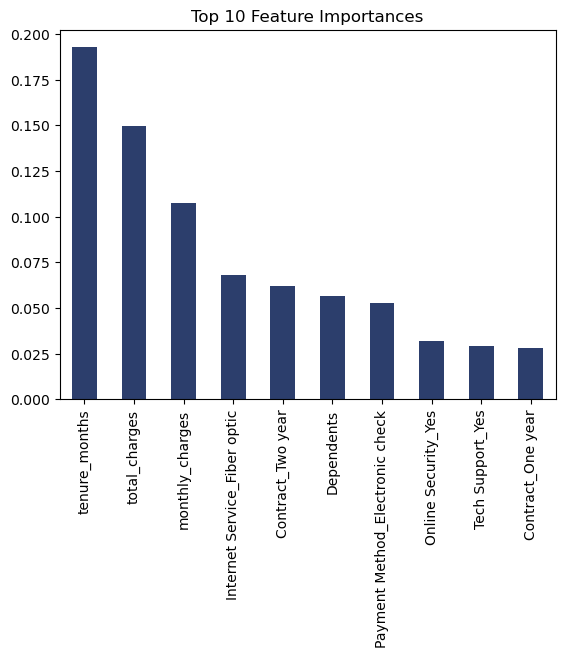

In [171]:
# Random Forest
# rf = RandomForestClassifier(n_estimators = 50)
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 20],
#     'min_samples_split': [2, 5],
#     'max_features': ['sqrt', 'log2'],
#     'class_weight': ['balanced', None]
# }
# gs = GridSearchCV(rf, param_grid, cv=5)
# gs.fit(X_train_scaled, y_train)
# print(gs.best_score_)

# gs.best_params_
# ^- the above piece of code generated the following parameters as optimal, but is excluded due to its slightly lengthy runtime of ~1 minute
rf = RandomForestClassifier(n_estimators = 200, max_depth = 10, max_features = 'sqrt', min_samples_split = 5)
rf.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf.predict(X_test_scaled)
y_prob = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluation
get_results(y_test, y_pred)
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances[:10].plot(kind='bar', color='#2c3e6c')
plt.title("Top 10 Feature Importances")
plt.show()

Notice that tenure months and the two charges columns are the most significant. This makes sense since total_charges is likely to be strongly correlated with the tenure_months [Instert EDA here?]

### 2.6. Train our Logisitic Regression Model

In [172]:
# Logistic Regression

log_reg = LogisticRegression(max_iter=1000)  # Initialise a log reg model

param_grid = [
    {'penalty': ['l2'], 'solver': ['lbfgs', 'newton-cg', 'saga'], 'C': [0.01, 0.1, 1, 10]},
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.01, 0.1, 1, 10]}
]

# This is a set of paramater combinations to check which gives the highest paramater, note that some solvers only work
# with specific penalty's hence the two dictionaries given

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')  # Perform the Grid Search aiming to maximise accuracy

grid_search.fit(X_train_scaled, y_train) # Fit a model with our found parameters

y_pred_log = grid_search.predict(X_test_scaled) # Generate some predictions

y_prob_log = grid_search.predict_proba(X_test_scaled)[:, 1]  # Generate the probabilities associated with the predictions

threshold = 0.3
y_prob_log = (y_prob_log >= threshold).astype(int)

# Evaluation
get_results(y_test, y_pred_log)
print("ROC AUC:", roc_auc_score(y_test, y_prob_log))



Results:

The confusion matrix for your predictions is:
[[900 109]
 [169 231]] 

The accuracy of your model is: 0.8026969481902059
The recall of your model is: 0.5775
The precision of your model is: 0.6794117647058824
The F1-score of your model is: 0.6243243243243243
ROC AUC: 0.7640436075322101


### 2.7. Compare our Two Models

As you can see our models produce very similar results! However the Random Forest model has a slightly higher accuracy of 0.806 (vs 0.803) and so is to be preferred

## 3. Extracting the customer list

We now use the the better of the two models (Random Forest) we have obtained to create our two lists of customers as required. **Note**: We made the conscious choice to only include the *customer ID* within the list of top 500 customers likely to churn as a form of abstraction to ensure that only the information necessary for the mailing list is given. Along with this, to ensure the full set of data is provided witin the full list of churn risk of each customer, we still included the top 500 customers likely to churn, along with more information than is given in the top 500 list.

In [173]:
ids = df_eng[['customer_id', 'churn_flag']] # Store ids for later
X_final =df_eng.drop(columns=drop_cols, errors='ignore').copy() # Drop columns so that we are using training columns
X_final['total_charges'] = X_final['total_charges'].replace({' ': median}) ## Fill values with the mean of our training data
X_final = scaler.transform(X_final)  # Scale the values using the scaler we used for our training data

df_eng['churn_risk'] = rf.predict_proba(X_final)[:, 1]  # Add a column to our dataframe with the churn risk probability according to our chosen model (random forest)
df_eng['churn_risk_log'] = grid_search.predict_proba(X_final)[:, 1]  # Same thing with logisitic regression model
sorted_by_rf = df_eng.sort_values(by = 'churn_risk', ascending=False)  # Sort values by risk
sorted_by_log = df_eng.sort_values(by = 'churn_risk_log', ascending=False)  # Sort values by risk

In [174]:
non_churners = sorted_by_rf.loc[sorted_by_rf['churn_flag'] == 'No']  # Select just the customers who haven't churned
top_500_customers = non_churners[['customer_id']].iloc[ :500, : ]  # Extract just the ids of the top 500 customers
top_500_customers.to_csv("top_500_customers.csv", index=False)  # Save that list as a csv

In [175]:
customer_risk_list = non_churners[['customer_id', 'churn_risk']]  # Select relevent columns of non churners
customer_risk_list.to_csv("customer_churn_risk.csv", index=False)  # Save as a csv

In [176]:
top_500_profiles = df[df['customer_id'].isin(top_500_customers['customer_id'])].copy()

# Separate numeric and categorical columns
numeric_cols = ['tenure_months', 'monthly_charges']
categorical_cols = ['Gender', 'Senior Citizen', 'Partner', 'Dependents',
                    'Contract', 'Internet Service', 'Payment Method']

# --- Numeric averages ---
numeric_summary = top_500_profiles[numeric_cols].mean().round(2)
# --- Categorical modes ---
categorical_summary = top_500_profiles[categorical_cols].mode().iloc[0]

# Combine into one easy summary table
summary = pd.concat([numeric_summary, categorical_summary])
summary.name = "Typical Top 500 Customer"
display(summary)


tenure_months                   11.7
monthly_charges                76.16
Gender                        Female
Senior Citizen                    No
Partner                           No
Dependents                        No
Contract              Month-to-month
Internet Service         Fiber optic
Payment Method      Electronic check
Name: Typical Top 500 Customer, dtype: object

In [177]:
# Create estimated lifetime value
df['estimated_lifetime_value'] = df['monthly_charges'] * df['tenure_months']

# Separate churned customers
churned_df = df[df['churn_value'] == 1].copy()

# Calculate the overall financial loss
total_loss = churned_df['estimated_lifetime_value'].sum()
print(f"Total Estimated Lifetime Value Lost to Churn: £{total_loss:,.0f}")

# Define threshold for top 10%
threshold = churned_df['estimated_lifetime_value'].quantile(0.90)

# Identify high-value churners
high_value_churners = churned_df[churned_df['estimated_lifetime_value'] >= threshold].copy()

# Calculate stats
num_high_value = len(high_value_churners)
share_high_value = num_high_value / len(churned_df)

# Total lifetime value among churners
total_churn_value = churned_df['estimated_lifetime_value'].sum()
high_value_total = high_value_churners['estimated_lifetime_value'].sum()

# Share of total churned lifetime value
value_share = high_value_total / total_churn_value

print(f"High-Value Threshold: £{threshold:,.0f}")
print(f"Number of High-Value Churners: {num_high_value}")
print(f"Share of Total Churners: {share_high_value:.1%}")
print(f"Total Lifetime Value of High-Value Churners: £{high_value_total:,.0f}")
print(f"Share of Total Churned Lifetime Value: {value_share:.1%}")


Total Estimated Lifetime Value Lost to Churn: £2,862,577
High-Value Threshold: £4,597
Number of High-Value Churners: 187
Share of Total Churners: 10.0%
Total Lifetime Value of High-Value Churners: £1,123,770
Share of Total Churned Lifetime Value: 39.3%


C:\Users\danjm\AppData\Local\Temp\ipykernel_26160\1989405212.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_eng['total_charges'].fillna(df_eng['total_charges'].median(), inplace=True)


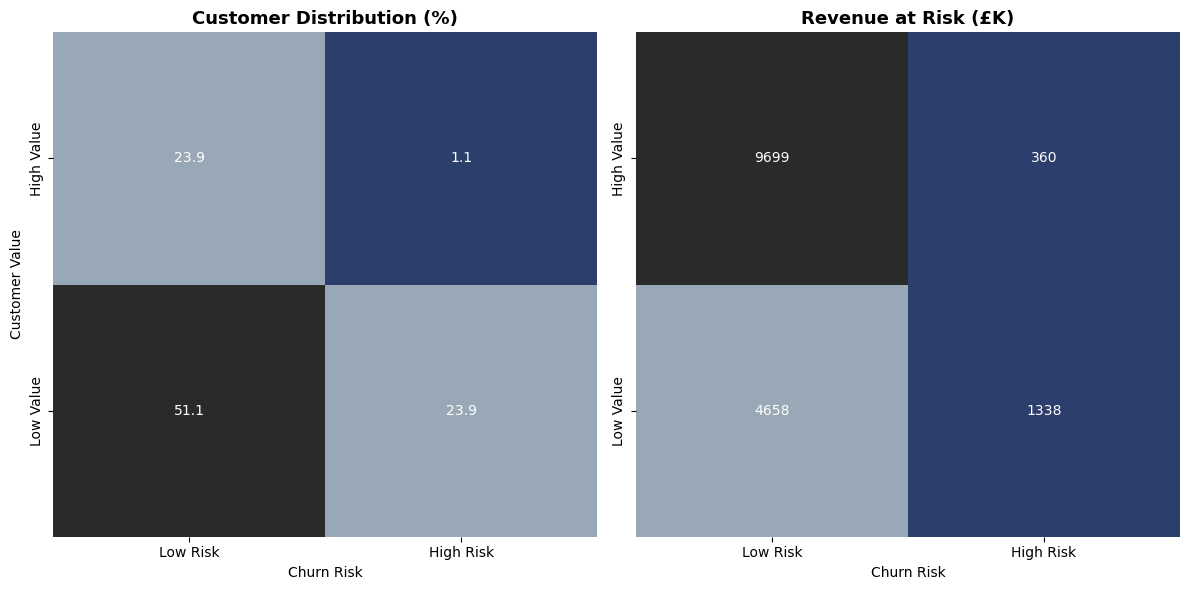

In [178]:
# --- Clean and prepare ---
df_eng['total_charges'] = (
    df_eng['total_charges'].replace(' ', np.nan).astype(float)
)
df_eng['total_charges'].fillna(df_eng['total_charges'].median(), inplace=True)

# --- Thresholds for segmentation ---
high_value_th = df_eng['total_charges'].quantile(0.75)
high_risk_th = df_eng['churn_risk'].quantile(0.75)

# --- Assign segments ---
df_eng['Retention Segment'] = df_eng.apply(
    lambda r: f"{'High' if r['total_charges'] >= high_value_th else 'Low'} Value / "
              f"{'High' if r['churn_risk'] >= high_risk_th else 'Low'} Risk",
    axis=1
)

# --- Summary stats ---
segment_pct = df_eng['Retention Segment'].value_counts(normalize=True) * 100
df_eng['estimated_lifetime_value'] = df_eng['monthly_charges'] * df_eng['tenure_months']
revenue_sum = df_eng.groupby('Retention Segment')['estimated_lifetime_value'].sum()

# --- Create matrices ---
order = ['High Value / Low Risk', 'High Value / High Risk', 'Low Value / Low Risk', 'Low Value / High Risk']
matrix_pct = np.array([[segment_pct.get(order[0], 0), segment_pct.get(order[1], 0)],
                       [segment_pct.get(order[2], 0), segment_pct.get(order[3], 0)]])
matrix_rev = np.array([[revenue_sum.get(order[0], 0), revenue_sum.get(order[1], 0)],
                       [revenue_sum.get(order[2], 0), revenue_sum.get(order[3], 0)]]) / 1000  # £K

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
titles = ['Customer Distribution (%)', 'Revenue at Risk (£K)']
data = [matrix_pct, matrix_rev]
cmaps = [five_palette, five_palette]

for ax, title, mat, cmap in zip(axes, titles, data, cmaps):
    sns.heatmap(mat, annot=True, fmt=".1f" if 'Distribution' in title else ".0f",
                cmap=cmap, cbar=False,
                xticklabels=['Low Risk', 'High Risk'],
                yticklabels=['High Value', 'Low Value'],
                ax=ax)
    ax.set_title(title, fontsize=13, weight='bold')
    ax.set_xlabel('Churn Risk')
    ax.set_ylabel('Customer Value' if 'Distribution' in title else '')

plt.tight_layout()
plt.show()


In [ ]:
high_value_high_risk = df_eng[df_eng['Retention Segment'] == 'High Value / High Risk']
high_value_high_risk_ids = high_value_high_risk[['customer_id']].copy()
high_value_high_risk_ids.to_csv("high_value_high_risk_customers.csv", index=False)